In [56]:
''' import '''
import scipy.io as io
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt

In [57]:
''' load data '''
data = io.loadmat('./data/hw3_prob3.mat')

A = data['A']               # (30720, 65536)
b = data['b']               # (30720, 1)
x_orig = data['x_orig']     # (256, 256)

M, N = x_orig.shape
K, _ = b.shape

In [58]:
''' function '''
def trunc(z, t):
    return np.sign(z)*np.minimum(np.abs(z), t)

# Chambolle-Pock (1d)

In [59]:
''' TV '''
Im = sp.eye(M)
Dn = sp.diags([1, -1, 1], offsets=(-(N-1), 0, 1), shape=(N,N))
D_h = sp.kron(Im, Dn)

In = sp.eye(N)
Dm = sp.diags([1, -1, 1], offsets=(-(M-1), 0, 1), shape=(M,M))
D_v = sp.kron(Dm, In)

In [60]:
''' hyper param '''
MAXITER = 10000
CRIT = 5e-5
MU = 1
# LAMBDA = 0.2 # fn에만 사용됨

L = sla.norm(A)**2
tau = 1 / L
sigma = 1 / (tau*L)

In [ ]:
''' Chambolle-Pock (1d) '''

fn_cham = []
xn_cham = []

x = np.zeros((M*N,1))
y1 = np.zeros((K,1))
y2 = np.zeros((M*N,1))
y3 = np.zeros((M*N,1))

for k in range(1, MAXITER):

    x_prev = x # x.flaten()과 차원이 같아야함

    # fn 느리지는 않음
    # fn = (MU/2)*la.norm(A@x - b)**2 + LAMBDA*la.norm(D_h@x, 1) + LAMBDA*la.norm(D_v@x, 1)

    # update y
    y1 = (y1 + sigma*(A@x) - sigma*MU*b) / (1 + sigma*MU)
    y2 = trunc(y2 + sigma*(D_h@x), sigma)
    y3 = trunc(y3 + sigma*(D_v@x), sigma)

    # update x
    x = np.maximum(x - tau*(A.T@y1 + D_h.T@y2 + D_v.T@y3), 0)

    theta = 1 / np.sqrt(1 + 2*MU*tau)
    tau = theta * tau
    sigma = sigma / theta

    x = x + theta*(x - x_prev) # acceleration

    # stop condition
    xcon = la.norm(x - x_prev) / la.norm(x)
    if (k >= 1) and (xcon < CRIT):
        break

    # history
    # fn_cham.append(fn)
    xn_cham.append(xcon)
    print(f'i = {k}, |x-x|/|x| = {xcon}') #, f = {fn:.8f}'

# opt
x_cham = x

i = 1, |x-x|/|x| = 1.0
i = 2, |x-x|/|x| = 0.5993628261480592
i = 3, |x-x|/|x| = 0.41049654470021507
i = 4, |x-x|/|x| = 0.3043236105902254
i = 5, |x-x|/|x| = 0.2380892532095378
i = 6, |x-x|/|x| = 0.1937137126224767
i = 7, |x-x|/|x| = 0.16235075734668514
i = 8, |x-x|/|x| = 0.13922916782403258
i = 9, |x-x|/|x| = 0.12158776438611382
i = 10, |x-x|/|x| = 0.10773941070523237
i = 11, |x-x|/|x| = 0.09660677993676134
i = 12, |x-x|/|x| = 0.08747590808003733
i = 13, |x-x|/|x| = 0.07985819454425945
i = 14, |x-x|/|x| = 0.07340969583931775
i = 15, |x-x|/|x| = 0.06788216388079515
i = 16, |x-x|/|x| = 0.06309238210294328
i = 17, |x-x|/|x| = 0.05890241077642352
i = 18, |x-x|/|x| = 0.0552065319232018
i = 19, |x-x|/|x| = 0.05192241917906988
i = 20, |x-x|/|x| = 0.04898503703976602
i = 21, |x-x|/|x| = 0.046342342805625256
i = 22, |x-x|/|x| = 0.043952203771690165
i = 23, |x-x|/|x| = 0.041780149318656035
i = 24, |x-x|/|x| = 0.03979770677168569
i = 25, |x-x|/|x| = 0.03798115214499977
i = 26, |x-x|/|x| = 0.03631

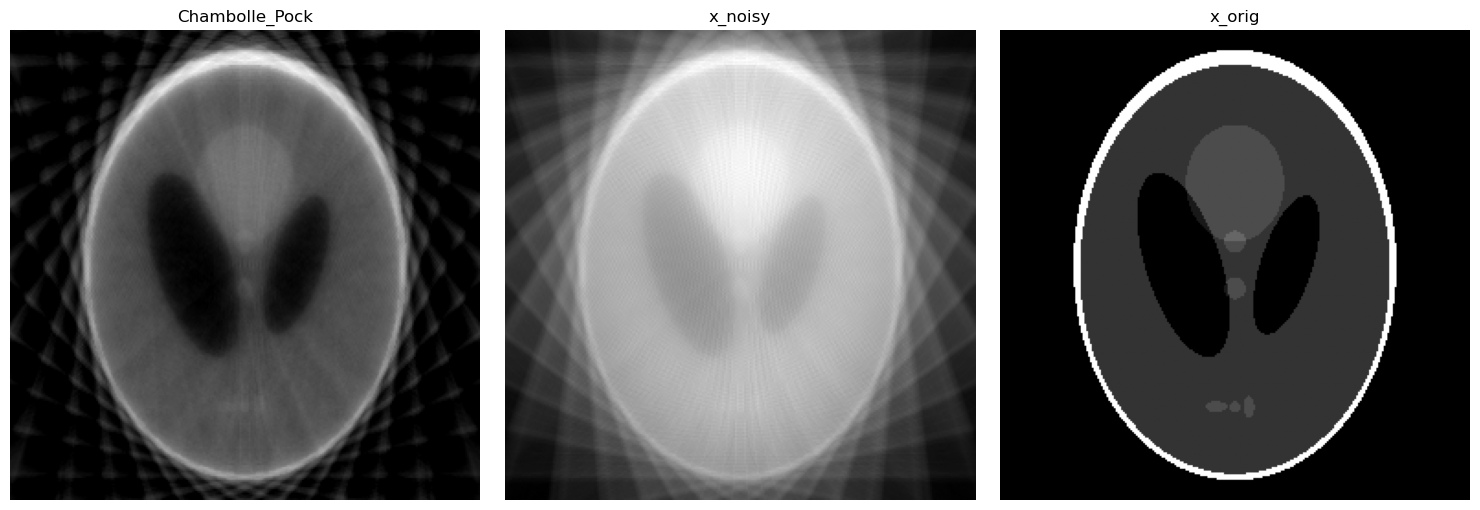

In [ ]:
''' plot '''
x_noisy = A.T@b

_, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(x_cham.reshape(M,N, order='F'), cmap='gray')
axs[0].set_title('Chambolle_Pock')
axs[0].axis('off')

axs[1].imshow(x_noisy.reshape(M,N, order='F'), cmap='gray')
axs[1].set_title('x_noisy')
axs[1].axis('off')

axs[2].imshow(x_orig, cmap='gray')
axs[2].set_title('x_orig')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Chambolle-Pock (1d)
D_h + D_v = D

In [45]:
''' TV '''
D = sp.vstack([D_h, D_v])   # [D_h, D_v] -> 하나로 처리

In [46]:
''' Chambolle-Pock (1d + D_h, D_v 통합) '''

fn_cham2 = []
xn_cham2 = []

x = np.zeros((M*N,1))
y1 = np.zeros((K,1))
y2 = np.zeros((2*(M*N),1)) # D_h, D_v 하나로 처리

for k in range(1, MAXITER):

    x_prev = x # x.flaten()과 차원이 같아야함

    # fn
    # fn = (MU/2)*la.norm(A@x - b)**2 + LAMBDA*la.norm(D@x, 1)

    # update y
    y1 = (y1 + sigma*(A@x) - sigma*MU*b) / (1 + sigma*MU)
    y2 = trunc(y2 + sigma*(D@x), sigma)

    # update x
    x = np.maximum(x - tau*(A.T@y1 + D.T@y2), 0)

    theta = 1 / np.sqrt(1 + 2*MU*tau)
    tau = theta * tau
    sigma = sigma / theta

    x = x + theta*(x - x_prev) # acceleration

    # stop condition
    xcon = la.norm(x - x_prev) / la.norm(x)
    if (k >= 1) and (xcon < CRIT):
        break

    # history
    # fn_cham2.append(fn)
    xn_cham2.append(xcon)
    print(f'i = {k}, |x-x|/|x| = {xcon}') #, f = {fn:.8f}'

# opt
x_cham2 = x

i = 1, |x-x|/|x| = 1.0
i = 2, |x-x|/|x| = 0.599350437726251
i = 3, |x-x|/|x| = 0.4104827079590915
i = 4, |x-x|/|x| = 0.30431132350498613
i = 5, |x-x|/|x| = 0.23807917499748976
i = 6, |x-x|/|x| = 0.19370573804269917
i = 7, |x-x|/|x| = 0.16234455981529244
i = 8, |x-x|/|x| = 0.139224397297016
i = 9, |x-x|/|x| = 0.1215841141272684
i = 10, |x-x|/|x| = 0.10773663263403162
i = 11, |x-x|/|x| = 0.09660468087598831
i = 12, |x-x|/|x| = 0.08747434026431782
i = 13, |x-x|/|x| = 0.07985704568643709
i = 14, |x-x|/|x| = 0.07340888058480194
i = 15, |x-x|/|x| = 0.06788161704036147
i = 16, |x-x|/|x| = 0.06309205351259496
i = 17, |x-x|/|x| = 0.05890226147688455
i = 18, |x-x|/|x| = 0.05520653134938415
i = 19, |x-x|/|x| = 0.051922543099108036
i = 20, |x-x|/|x| = 0.04898526604141718
i = 21, |x-x|/|x| = 0.04634266117943662
i = 22, |x-x|/|x| = 0.04395259868128904
i = 23, |x-x|/|x| = 0.04178061017927772
i = 24, |x-x|/|x| = 0.03979822478046484
i = 25, |x-x|/|x| = 0.03798171992260961
i = 26, |x-x|/|x| = 0.03631117

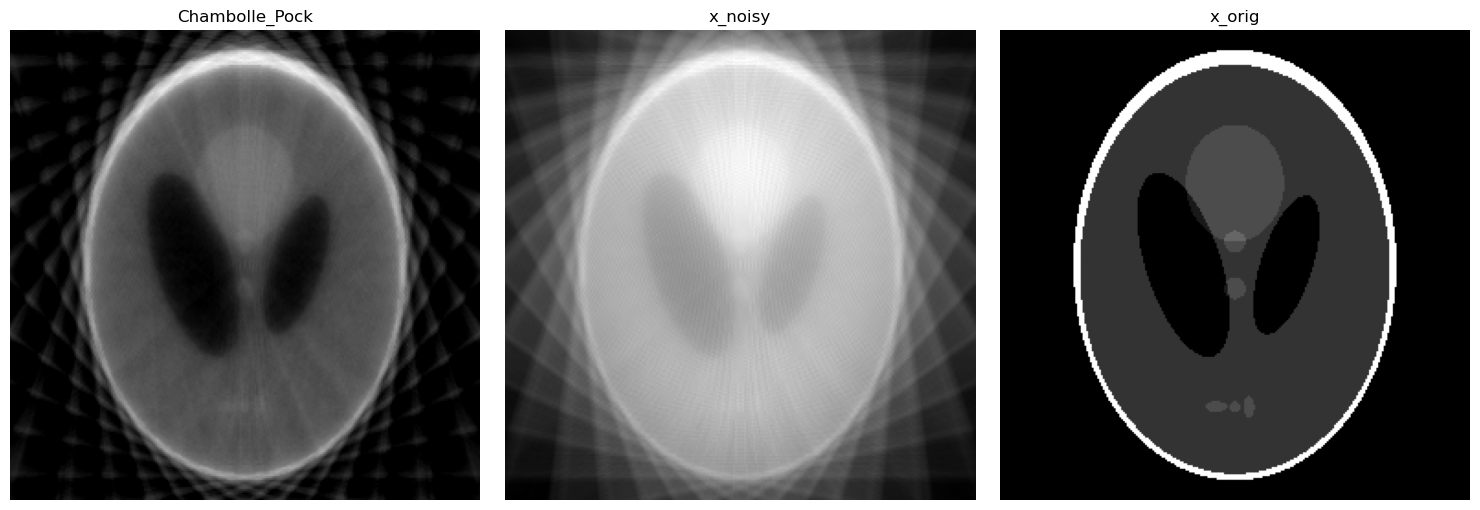

In [52]:
''' plot '''
x_noisy = A.T@b

_, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(x_cham2.reshape(M,N, order='F'), cmap='gray')
axs[0].set_title('Chambolle_Pock')
axs[0].axis('off')

axs[1].imshow(x_noisy.reshape(M,N, order='F'), cmap='gray')
axs[1].set_title('x_noisy')
axs[1].axis('off')

axs[2].imshow(x_orig, cmap='gray')
axs[2].set_title('x_orig')
axs[2].axis('off')

plt.tight_layout()
plt.show()